# Multi-class Classification
In this exercise, we use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). 
Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. 
In this exercise, we extend the previous implementation of  logistic regression and apply it to one-vs-all classification.

## Datasets
We are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits.  After loading, matrices of the correct dimensions and values will appear in your program’s memory.

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of a digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $ X $. This gives us a $ 5000 \times 400 $ matrix $ X $ where every row is a training example for a handwritten digit image.

$$
X = \begin{bmatrix}
-(x^{(1)})^T- \\
-(x^{(2)})^T- \\
\vdots \\
-(x^{(m)})^T-
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector $ y $ that contains labels for the training set. In this dataset, the digit zero was mapped to the value 10 in order to make things more compatible with Octave/MATLAB indexing. However, since this implementation is in python which starts indexing at 0, we change the value back to zero.

> Note that in this exercise, we won't add an intercept in order to keep implementation simple.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.style.use('ggplot')

In [154]:
data1 = scipy.io.loadmat('ex3data1.mat')
X1 = data1['X']
y1 = data1['y']
y1[y1==10] = 0  # Change mapping of zero digit to 0
y1=y1.T[0]      # Convert vertical vector to horizontal array
X1.shape, y1.shape

((5000, 400), (5000,))

## Visualizing the data
You will begin by visualizing a subset of the training set. We randomly select 100 rows from X and passes those rows to the displayData function. 
This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. Note the need to rotate, then flip the array in order to show correctly.

6

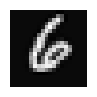

In [155]:
plt.figure(figsize=(1, 1))
n = 3000
array =  np.rot90(np.fliplr(X1[3000].reshape(20, 20)))
plt.imshow(array, cmap='gray')
plt.axis('off')
y1[n]

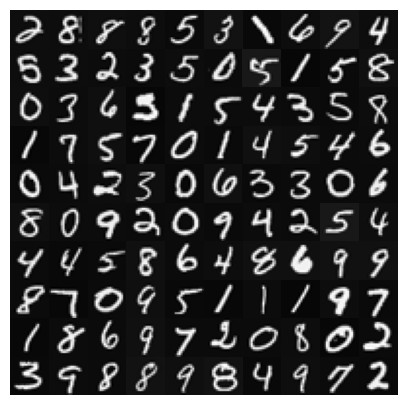

array([[2, 8, 8, 8, 5, 3, 1, 6, 9, 4],
       [5, 3, 2, 3, 5, 0, 5, 1, 5, 8],
       [0, 3, 6, 5, 1, 5, 4, 3, 5, 8],
       [1, 7, 5, 7, 0, 1, 4, 5, 4, 6],
       [0, 4, 2, 3, 0, 6, 3, 3, 0, 6],
       [8, 0, 9, 2, 0, 9, 4, 2, 5, 4],
       [4, 4, 5, 8, 6, 4, 8, 6, 9, 9],
       [8, 7, 0, 9, 5, 1, 1, 1, 9, 7],
       [1, 8, 6, 9, 7, 2, 0, 8, 0, 2],
       [3, 9, 8, 8, 9, 8, 4, 9, 7, 2]], dtype=uint8)

In [156]:
def displayData(X, y, plot_size=10, fig_size=5):
    indices = np.random.choice(len(X), plot_size*plot_size, replace=False)
    labels = y[indices]
    selected_images = X[indices]
    fig, axes = plt.subplots(plot_size, plot_size, figsize=(fig_size, fig_size))
    for i, ax in enumerate(axes.flat):
        rotated_image = np.rot90(np.fliplr((selected_images[i].reshape(20, 20))))
        ax.imshow(rotated_image.reshape(20, 20), cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return labels.reshape(plot_size, plot_size)

displayData(X1, y1)

## Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.

### Vectorizing the Cost Function

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right].
$$

To compute each element in the summation, we have to compute $ h_\theta(x^{(i)}) $ for every example $ i $, where:

$$
h_\theta(x^{(i)}) = g(\theta^T x^{(i)}) \quad \text{and} \quad g(z) = \frac{1}{1 + e^{-z}}
$$

is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $ X $ and $ \theta $ as:

$$
X = 
\begin{bmatrix}
- (x^{(1)})^T - \\
- (x^{(2)})^T - \\
\vdots \\
- (x^{(m)})^T - 
\end{bmatrix}
\quad \text{and} \quad
\theta = 
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n
\end{bmatrix}.
$$

Then, by computing the matrix product $ X\theta $, we have:

$$
X\theta = 
\begin{bmatrix}
- (x^{(1)})^T \theta - \\
- (x^{(2)})^T \theta - \\
\vdots \\
- (x^{(m)})^T \theta -
\end{bmatrix} = 
\begin{bmatrix}
- \theta^T x^{(1)} - \\
- \theta^T x^{(2)} - \\
\vdots \\
- \theta^T x^{(m)} -
\end{bmatrix}.
$$

In the last equality, we used the fact that $ \mathbf{a}^T \mathbf{b} = \mathbf{b}^T \mathbf{a} $ if $ \mathbf{a} $ and $ \mathbf{b} $ are vectors. This allows us to compute the products $ \theta^T x^{(i)} $ for all our examples $ i $ in one line of code.

### Vectorizing the Cost
We write the unregularized cost function `lrCostFunction`. The implementation should use the strategy we presented above to calculate $ \theta^T x^{(i)} $. A fully vectorized version of `lrCostFunction` should not contain any loops.

### Vectorizing the Gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $ j $-th element is defined as

$$
\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x^{(i)}_j.
$$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $θ_j$. The partial derivatives explicitly for all $\theta_j$:

$$
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix}
=
\frac{1}{m}
\begin{bmatrix}
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_0^{(i)} \\
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_1^{(i)} \\
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_2^{(i)} \\
\vdots \\
\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_n^{(i)}
\end{bmatrix}
= \frac{1}{m} X^T \left( h_\theta(x) - y \right)
\space
where:
\space
h_\theta(x) - y = 
\begin{bmatrix} 
h_\theta\left( x^{(1)} \right) - y^{(1)} \\
h_\theta\left( x^{(2)} \right) - y^{(2)} \\
\vdots \\
h_\theta\left( x^{(m)} \right) - y^{(m)}
\end{bmatrix}
$$

Note that $x^{(i)}$ is a vector, while $h_\theta\left( x^{(i)} \right) - y^{(i)}$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = ( h_\theta(x^{(i)}) - y^{(i)} )$, and observe that:

$$
\beta_i x^{(i)} 
= 
\begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \dots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = X^T \beta,
$$

where the values $\beta_i = \left( h_\theta(x^{(i)}) - y^{(i)} \right)$. The expression above allows us to compute all the partial derivatives without any loops. We implement Equation (1) to compute the correct vectorized gradient.




In [157]:
def lrHypothesis(theta, X):
    return 1 / (1 + np.exp(-X @ theta))

def lrCostFunction(X, y, epsilon=1e-3):
    def cost(theta):
        m = len(y)
        h = lrHypothesis(theta, X)
        return np.sum(-y*np.log(h+epsilon) - (1-y)*np.log(1-h+epsilon)) / m
    return cost

def lrGradient(X, y):
    def gradient(theta):
        m = len(y)
        h = lrHypothesis(theta, X)
        return ((1 / m) * (h - y) @ X)
    return gradient

In [158]:
theta0 = np.zeros(400)  
theta1 = np.ones(400)
lrHypothesis(theta0, X1), lrHypothesis(theta1, X1)

(array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [159]:
lrCostFunction(X1, y1)(theta0), lrCostFunction(X1, y1)(theta1)

(-17.0022697762729, 1390.7569236443342)

In [160]:
lrGradient(X1, y1)(theta0).shape, lrGradient(X1, y1)(theta1).shape

((400,), (400,))

In [161]:
def logistic(X, y, theta_0=None):
    if theta_0 is None: theta_0 = np.zeros(X.shape[1])
    cost, gradients = lrCostFunction(X, y), lrGradient(X, y)
    result = scipy.optimize.minimize(fun=cost, jac=gradients, x0=theta_0, method='BFGS')
    return result

### Predicting Zero digits
Now, we predict zero digits. These are at the start of the dataset, and hence the high probabilities for the first part of the indices.

In [162]:
y_zeros = (y1==0)*1.0
y_zeros

array([1., 1., 1., ..., 0., 0., 0.])

In [163]:
l_zero = logistic(X1, y_zeros)
l_zero

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.016623704240970146
        x: [ 0.000e+00  0.000e+00 ...  1.072e-05  0.000e+00]
      nit: 60
      jac: [ 0.000e+00  0.000e+00 ... -5.065e-11  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 131
     njev: 119

[9.99961295e-01 9.99890589e-01 9.85504709e-01 ... 2.07465255e-09
 1.32790558e-09 1.60131857e-03]
[1. 1. 1. ... 0. 0. 0.]


<BarContainer object of 5000 artists>

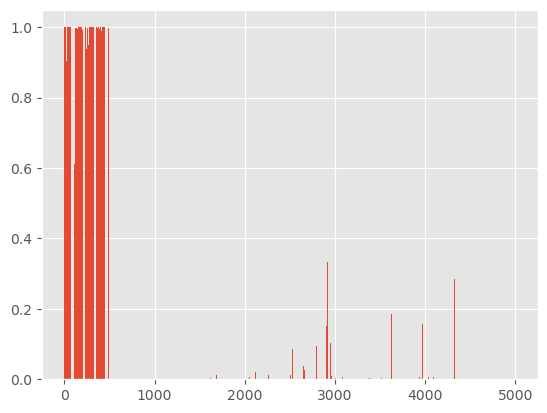

In [164]:
H_0 = lrHypothesis(l_zero.x, X1)
print(H_0)
print(np.round(H_0))
plt.bar(range(len(H_0)), H_0)

### Predicting nine digits
Now, we predict nine digits. These are at the end of the dataset, and hence the high probabilities for the latter part of the indices

[8.02610950e-04 1.37630763e-05 9.37484497e-04 ... 8.56807423e-01
 8.27314770e-01 3.93975392e-01]
[0. 0. 0. ... 1. 1. 0.]


<BarContainer object of 5000 artists>

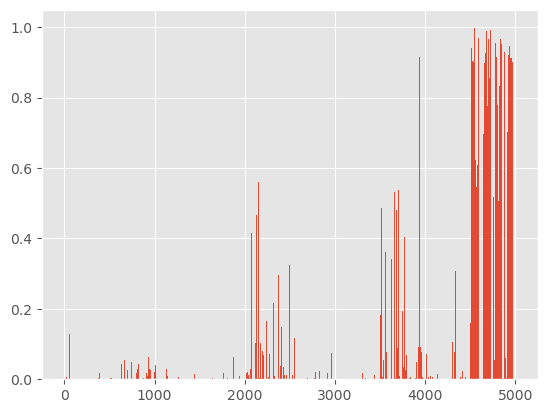

In [165]:
y_nines = (y1==9)*1.0
l_nine = logistic(X1, y_nines)
H_9 = lrHypothesis(l_nine.x, X1)
print(H_9)
print(np.round(H_9))
plt.bar(range(len(H_9)), H_9)

### Vectorizing Regularized Logistic Regression

After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as:

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left( -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right) + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2.
$$

Note that you should not be regularizing $ \theta_0 $, which is used for the bias term. Correspondingly, the partial derivative of the regularized logistic regression cost with respect to $ \theta_j $ is defined as:

$$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_0^{(i)}
\space for \space j = 0
$$

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j \space for \space j \geq 1
$$

Now, modify your code in the `lrCostFunction` to account for regularization. Once again, you should not introduce any loops into your code.

> We skip this section for now...

In [166]:
 pass

## One-vs-all Classification

In this part of the exercise, we implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $ K $ classes in our dataset. In the handwritten digits dataset, $ K = 10 $, but your code should work for any value of $ K $.

`oneVsAll` trains one classifier for each class. In particular, the code should return all the classifier parameters in a matrix $ \Theta \in \mathbb{R}^{K \times (N+1)} $, where each row of $ \Theta $ corresponds to the learned logistic regression parameters for one class. You can do this with a "for"-loop from $ 1 $ to $ K $, training each classifier independently. Note that the $ y $ argument to this function is a vector of labels from $ 0 $ to $ 9 $.

When training the classifier for class $ k \in \{1, \ldots, K\} $, you will want an $ m $-dimensional vector of labels $ y $, where $ y_j \in 0, 1$ indicates whether the j-th
training instance belongs to class k ($y_j = 1$), or if it belongs to a different
class ($y_j = 0$). You may find logical arrays helpful for this task.

We use `scipy.optimize.minimize` as our minimization function. 


In [167]:
def oneVsAll(X, y):
    thetas = []
    theta0 = np.zeros(X.shape[1])
    for k in range(10):
        y_k = (y==k)*1.0
        cost = lrCostFunction(X, y_k)
        gradient = lrGradient(X, y_k)
        objective = scipy.optimize.minimize(fun=cost, jac=gradient, x0=theta0, method='BFGS')
        thetas.append(objective.x)
    return np.array(thetas)
    

In [168]:
thetas = oneVsAll(X1, y1)
thetas.shape

(10, 400)

In [169]:
thetas @ X1[0]

array([ 10.15950817, -19.06075832,  -8.24192511,  -8.00346794,
       -44.54871838,  -9.59027263, -10.50329651, -24.14591333,
        -8.96534378,  -7.12683752])

## One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image.
For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. 
Our one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 2,..., or K) as the prediction for the input example. The code in `predictOneVsAll` uses the one-vs-all classifier to make predictions.

Finally, we call the function using the learned value of Θ on all the data. You should see that the training set accuracy is around 94% (i.e., it classifies 94% of the examples in the training set correctly).

In [170]:
def cost_multi(thetas, x):
    return 1 / (1 + np.exp(-thetas @ x))

p1 = cost_multi(thetas, X1[0])
p1, np.argmax(p1)# X1[0] is digit zero

(array([9.99961295e-01, 5.27251517e-09, 2.63307384e-04, 3.34189558e-04,
        4.49508004e-20, 6.83860966e-05, 2.74450713e-05, 3.26259435e-11,
        1.27745375e-04, 8.02610950e-04]),
 0)

In [171]:
def predictOneVsAll(thetas, x):
    predictions = 1 / (1 + np.exp(-thetas @ x))
    return np.argmax(predictions)

In [172]:
y_true = np.array([y1[i] for i in range(len(y1))])
y_hat = np.array([predictOneVsAll(thetas, X1[i]) for i in range(len(X1))])

In [1]:
accuracy = sum(y_hat == y_true) / len(y_true)
accuracy

NameError: name 'y_hat' is not defined

# Neural Networks
In this exercise, we implement a neural network to recognize handwritten digits using the MNIST training set. 
The neural network will be able to represent complex models that form non-linear hypotheses. 
For this week, we will be using parameters from a neural network that we have already trained. 
The goal is to implement the feedforward propagation algorithm to use our weights for prediction.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.style.use('ggplot')

In [60]:
data1 = scipy.io.loadmat('ex3data1.mat')
X1 = data1['X']
y1 = data1['y']
y1 = y1.T[0]      # Convert vertical vector to horizontal array
X1.shape, y1.shape

((5000, 400), (5000,))

## Model representation
This neural network has 3 layers – an input layer, a hidden layer and an output layer. 
Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). 

We have been provided with a set of network parameters (Θ(1) ,Θ(2))
already trained by us. These are stored in `ex3weights.mat` and will be
loaded into `Theta1` and `Theta2`.
 
The parameters have dimensions that are sized for a neural network with 25 units in the second 
layer and 10 output units (corresponding to the 10 digit classes).

![Neural Network Model](neuralnetwork.png)

In [61]:
weights = scipy.io.loadmat('ex3weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

## Feedforward Propagation and Prediction
Now we implement feedforward propagation for the neural network. 
The code in `predict` returns the neural network’s prediction.

We implement the feedforward computation that computes $ (h_\theta(x^{(i)}) )$ for every example $( i)$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output, $( (h_\theta(x))_k )$. 

Finally, we call  `predict` function using the loaded set of parameters for `Theta1` and `Theta2` on all the data, and we calculate the accurasy of the model. We should see that the accuracy is about 97.5%. 

In [62]:
def activation(x, Theta):
    return 1 / (1 + np.exp(-Theta @ x))

def predict(x, Thetas=[Theta1, Theta2]):
    layer = x
    for Theta in Thetas:
        layer = np.hstack((1.0, layer.copy()))
        layer = activation(layer, Theta)
    return layer

In [66]:
n = 1000 # let's predict the 1000th element
print(predict(X1[n]))
print(np.round(predict(X1[n])))
y1[n], np.argmax(predict(X1[n])) + 1

[3.85613838e-04 9.68544083e-01 1.92134752e-03 1.38526834e-04
 3.20810992e-03 7.01713717e-04 6.45235792e-04 1.66993752e-02
 1.00700486e-01 3.25396474e-03]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


(2, 2)

In [64]:
# Note that the NN is trained with 1 indexing, and zero digit mapping to 10
# Hence need to add one to our predicted indices
y_true = y1
y_hat = np.array([np.argmax(predict(X1[i]))+1 for i in range(len(X1))])

In [65]:
accuracy = sum(y_hat == y_true) / len(y_true)
accuracy

0.9752